We are going to do the following

Train the classifier
label the unlabelled data.
Check the scores

Acquiring and cleaning the text data

In [1]:
import pandas as pd
from IPython.display import display
from nltk.corpus import stopwords

df=pd.read_excel('08052019_coded_cases_training_data.xlsx')

In [2]:
df.columns

Index(['case', 'link', 'Mis_Dis', 'Mis_Dis text', 'Social_Impact',
       'Social_Impact text', 'observed behaviours', 'observed behaviours text',
       'note'],
      dtype='object')

split to 3 sets change to lower case, remove punctuation and remove stopwords

In [3]:
stop = stopwords.words('english')

from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

#this is done so that i can apply lambda function without too much for loops by mapping the stem function to the words
def mapstem(lst):
    return [stemmer.stem(i) for i in lst]



#takes a label,text df and processes the df
def txt_preprocessing(df):
    col = df.columns[1]
    #lower case
    df[col] = df[col].apply(lambda x: " ".join(x.lower() for x in x.split()))
    #remove "\n"
    df = df.replace('\n',' ', regex=True)
    #remove punctuation
    df[col] = df[col].str.replace('[^\w\s]','')
    #remove stopwords
    df[col] = df[col].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    #tokenize words
    df[col] = df[col].apply(word_tokenize)
    #stem words
    df[col] = df[col].apply(lambda x: mapstem(x))
    #stitching
    df[col] = df[col].apply(lambda x: ' '.join(x))
    
    return df



mis_dis = df[['Mis_Dis', 'Mis_Dis text']].dropna()
social_impact = df[['Social_Impact','Social_Impact text']].dropna()
ob_behaviour = df[['observed behaviours', 'observed behaviours text']].dropna()

#cleaning the df into training data
mis_dis=txt_preprocessing(mis_dis)
mis_dis.columns=['target','data']
social_impact=txt_preprocessing(social_impact)
social_impact.columns=['target','data']
ob_behaviour=txt_preprocessing(ob_behaviour)
ob_behaviour.columns=['target','data']
combi=pd.concat([mis_dis,social_impact])

display(mis_dis)

,target,data
0,Smear,polic said group link free papua movement opm ...
1,Smear,resid one villag banti said secur forc block a...
2,Smear,indonesian militari general gatot nurmantyo na...
3,Smear,hendrik wanmang describ command arm group goe ...
4,Rumour,follow seri bomb incid chain messag circul tex...
5,Rumour,specif threat particular target therefor text ...
6,Rumour,public call avoid spread unverifi inform pass ...
7,Rumour,social media user share unverifi text messag w...
8,Rumour,also mention certain psychologist counsel expe...
9,Rumour,anoth forward messag claim arm forc philippin ...


# Training the Data
downloading the trainings and testing set

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
import seaborn as sns;sns.set()
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from sklearn import metrics
import IPython.display as display
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_score

        

def make_nb_model(df):
    train, test = train_test_split(df, test_size=0.2)
    '''
    print(train.shape, train.target.value_counts())
    print(test.shape, test.target.value_counts())
    '''

    model = make_pipeline(TfidfVectorizer(),MultinomialNB())

    model.fit(train.data,train.target) #see the above for example
    labels = model.predict(test.data)
    
    #remove the '''''' to show the confusion matrix and accuracy score
    
    mat = confusion_matrix(test.target,labels)
    sns.heatmap(mat.T,square=True,fmt='d',cbar=False,annot=True)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    
    print("accuracy",metrics.accuracy_score(test.target, labels))
    #print(metrics.roc_auc_score(test.target, labels)) #above 0.5 is nice, 1 is best
    
    #cross-validating
    print("cross validating",cross_val_score(model, train.data, train.target, cv=5),cross_val_score(model, train.data, train.target, cv=5).mean())
    
    accuracy = cross_val_score(model, train.data, train.target, cv=5).mean()
    
    #print(classification_report(test.target, labels))
    
    return model, train, accuracy

def make_LR(df):
    from sklearn.linear_model import LogisticRegression
    train, test = train_test_split(df, test_size=0.2)
    print(train.shape, train.target.value_counts())
    print(test.shape, test.target.value_counts())

    model = make_pipeline(TfidfVectorizer(),LogisticRegression())

    model.fit(train.data,train.target) #see the above for example
    labels = model.predict(test.data)
    
    mat = confusion_matrix(test.target,labels)
    sns.heatmap(mat.T,square=True,fmt='d',cbar=False,annot=True)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    
    print("accuracy",metrics.accuracy_score(test.target, labels))
    #print(metrics.roc_auc_score(test.target, test.data)) #above 0.5 is nice, 1 is best

    
    return model, train



accuracy 0.75
cross validating [0.52941176 0.58823529 0.53333333 0.64285714 0.71428571] 0.601624649859944


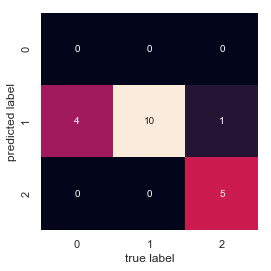

In [5]:
mis_dis_model, mis_dis_train, mis_dis_accuracy = make_nb_model(mis_dis)

accuracy 0.4
cross validating [0.3        0.375      0.66666667 0.33333333 0.5       ] 0.43499999999999994


C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


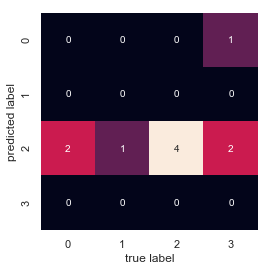

In [7]:
social_impact_model, social_impact_train, social_impact_accuracy = make_nb_model(social_impact)

accuracy 0.5172413793103449
cross validating [0.38461538 0.32       0.34782609 0.45       0.6       ] 0.42048829431438123


C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


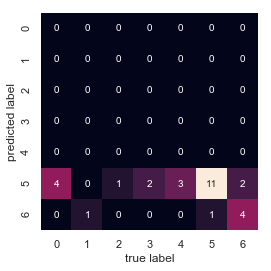

In [8]:
combi_model, combi_train, combi_accuracy = make_nb_model(combi)

# Using the model

In [ ]:
def predict_category(text,model,train):
    pred = model.predict([text])
    pred_prob = pd.DataFrame(model.predict_proba([text]),columns=model.classes_).sort_values(by=0, ascending=False, axis=1)
    df = pred_prob
    df['predicted'] = pred
    return df

def predict_category_OC(text,model,train):
    pred = model.predict([text])
    pred_prob = pd.DataFrame(model.decision_function([text]),columns=model.classes_).sort_values(by=0, ascending=False, axis=1)
    df = pred_prob
    df['predicted'] = pred
    return df

In [ ]:
#testing
from IPython.display import display

#use this value as a discard threshold
display("empty mis dis",predict_category(" ",mis_dis_model, mis_dis_train))
conspiracy_true_text = 'National Police arrested Ahmad Rifai, 37, for allegedly spreading fake news through a  Facebook post in which he said the suicide bomb attack that killed three police officers and injured 16 others in East Jakarta last week, was a police plot.'
hoax_true_text = 'Netizens worried on circulated rumors that Baguio City and other municipalities in Benguet was on red alert after alleged members of New People’s Army burned two trucks containing copper concentrate in Ampucao itogon, Benguet Thursday.'
misinformation_true_text = 'Hendrik Wanmang, who described himself as a commander of the armed group that goes by the Indonesian acronym TNP, said in an interview on Friday (local time) that Banti and Kimbeli villagers cannot go to an area the separatists defined as a battlefield with security forces because it is unsafe.But otherwise villagers are free to go to their farms and move about as they please, he said. On Thursday, police said a group of about 100, including 25 gunmen, were occupying the two villages and preventing 1,300 people from leaving.'

display("conspiracy theory",predict_category(conspiracy_true_text,mis_dis_model, mis_dis_train))
display("hoax",predict_category(hoax_true_text,mis_dis_model, mis_dis_train))
display("misinformation",predict_category(misinformation_true_text,mis_dis_model, mis_dis_train))


In [ ]:
import glob

path = r'C:\Users\User\Desktop\Terrorism and Fake News Project\00_Pipeline_0\2.Datasets\h5 files'

all_files = glob.glob(path + "/*.h5")

li = []

for filename in all_files:
    li.append(filename)

In [ ]:
#takes a series and processes the text
def txt_preprocess(series):
    #convert to df
    df = series.to_frame().transpose()
    df.columns=['link','gtd_id','txts']
    #melting list
    df = df.txts.apply(pd.Series)\
    .merge(df, right_index = True, left_index = True)\
    .drop(["txts"], axis = 1)\
    .melt(id_vars = ['link','gtd_id'], value_name = "txt") \
    .drop("variable", axis = 1) \
    .drop_duplicates()\
    .dropna()
    #display(df.tail())
    #display(type(df['txt'][0]))
    
    col = 'txt'
    #lower case
    df[col] = df[col].apply(lambda x: " ".join(x.lower() for x in x.split()))
    #remove "\n"
    df = df.replace('\n',' ', regex=True)
    #remove punctuation
    df[col] = df[col].str.replace('[^\w\s]','')
    #remove stopwords
    df[col] = df[col].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    
    #tokenize words
    df[col] = df[col].apply(word_tokenize)
    #stem words
    df[col] = df[col].apply(lambda x: mapstem(x))
    #stitching
    df[col] = df[col].apply(lambda x: ' '.join(x))
    
    return df

#this method quite computationally expensive cos you are running things at o(n^2)
class NothingToAnalyseError(Exception):
    pass
    


#gives the maximum value of h5
def label_h5(h5):
    series=pd.read_pickle(h5)
    #print(series[2])
    #print(type(series[2]))
    if series[2] == []:
        raise NothingToAnalyseError
        print('Nothing to analyse!')
    else:
        frame = txt_preprocess(series)
        #print('frame len:' + str(len(frame)))
        #display(frame)

        #create a df with predicted values and text
        def pred_df(frame,model,train):
            df = pd.DataFrame()
            for i in range(len(frame)):
                txt = frame['txt'].iloc[i]
                #text=pd.DataFrame([txt])
                #text.columns=['text']
                dfa= predict_category(txt,model,train)
                df = pd.concat([df,dfa], sort=True) #sort=True to silence warnings
            df = df.reset_index(drop=True)
            return df

        df2=pred_df(frame,mis_dis_model, mis_dis_train)
        df3=pred_df(frame,social_impact_model,social_impact_train)


        frame = pd.concat([df2,df3, frame], axis=1, sort=True)
        frame = frame.dropna()
        frame = frame.reset_index()
        return frame
    
def maxframe(frame):
    def maxcol(col,frame):
        val = pd.DataFrame([frame[col].max()])
        val.columns=[col]
        #print(val)
        #print('id: '+ str(frame[col].idxmax()))
        txt = pd.DataFrame([frame['txt'].iloc[frame[col].idxmax()]])
        txt.columns=[col+' text']
        #print(txt)
        maximum_col = pd.concat([val,txt],axis=1)
        return maximum_col
    cols = ['Conspiracy Theory','Rumour','Smear','Erode trust in authorities','Identity','Inciting fear and panic','Public safety']
    maxframe=pd.DataFrame()
    for i in cols:
        lframe = maxcol(i,frame)
        maxframe=pd.concat([maxframe,lframe],axis=1)
    
    link = pd.DataFrame([frame['link'][0]])
    link.columns=['link']
    maxframe = pd.concat([maxframe,link],axis=1)
    
    return maxframe



In [ ]:
li[1597]

In [ ]:
pd.read_pickle(li[1597])

In [ ]:
maxframe(label_h5(li[15])) #too huge

In [ ]:
len(li) #to know how much i need

In [ ]:
for i in range(3,13595):
    try:
        print(i,end='\r')
        d=maxframe(label_h5(li[i]))
        #print(ndf,end='\r')
        #print(d.columns)
        d[['Conspiracy Theory', 'Conspiracy Theory text','link']].copy().to_csv('highest_link_score_CT.csv',mode='a',header=None)
        d[['Rumour', 'Rumour text','link']].copy().to_csv('highest_link_score_rumour.csv',mode='a',header=None)
        d[['Smear', 'Smear text','link']].copy().to_csv('highest_link_score_s.csv',mode='a',header=None)
        d[['Identity', 'Identity text','link']].copy().to_csv('highest_link_score_identity.csv',mode='a',header=None)
        d[['Inciting fear and panic', 'Inciting fear and panic text','link']].copy().to_csv('highest_link_score_fear.csv',mode='a',header=None)
        d[['Public safety', 'Public safety text','link']].copy().to_csv('highest_link_score_safety.csv',mode='a',header=None)

        
        
        #d.to_csv('highest_link_score2.csv',mode='a',header=None)
    except NothingToAnalyseError:
        continue

Cleaning the dataset that has been labelled by deducting baseline

In [ ]:
import pandas as pd
df = pd.read_excel('highest_link_score.xlsx').drop_duplicates().drop('Unnamed: 0',axis=1)
df.columns

base_md = predict_category(" ",mis_dis_model, mis_dis_train)
base_si = predict_category(" ",social_impact_model,social_impact_train)
baseline = pd.concat([base_md,base_si],axis=1).drop('predicted',axis=1)

for i in df.iloc[:,0:6]:
    df[i]=df[i].apply(lambda x: x - baseline[i])
df.to_csv('md_si.csv')

In [7]:
lst = []
for i in range (1000):
    mis_dis_model, mis_dis_train, mis_dis_accuracy = make_nb_model(mis_dis)
    lst.append(mis_dis_accuracy)
max(lst)

0.7554621848739497

In [8]:
lst = []
for i in range (1000):
    social_impact_model,social_impact_train, social_impact_accuracy = make_nb_model(social_impact)
    lst.append(social_impact_accuracy)
max(lst)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimu

0.6009523809523809